## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [12]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])

    return model

In [13]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [15]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""





reduce_lr_factor = [0.5, 0.75]
redice_lr_patient = [5, 10]

In [16]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=reduce_patient, 
                                  verbose=1)
    
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5


W0723 18:38:35.435487 32364 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0723 18:38:35.797122 32364 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0723 18:38:35.820163 32364 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
__________

W0723 18:38:36.072501 32364 deprecation.py:323] From C:\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 21s 413us/step - loss: 2.2532 - acc: 0.2561 - val_loss: 2.1063 - val_acc: 0.3060
Epoch 2/25
50000/50000 [==============================] - 7s 145us/step - loss: 1.7664 - acc: 0.3834 - val_loss: 1.9066 - val_acc: 0.3402
Epoch 3/25
50000/50000 [==============================] - 6s 125us/step - loss: 1.6400 - acc: 0.4259 - val_loss: 1.7165 - val_acc: 0.3994
Epoch 4/25
50000/50000 [==============================] - 6s 120us/step - loss: 1.5694 - acc: 0.4499 - val_loss: 1.6693 - val_acc: 0.4098
Epoch 5/25
50000/50000 [==============================] - 6s 121us/step - loss: 1.5167 - acc: 0.4687 - val_loss: 1.6117 - val_acc: 0.4306
Epoch 6/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.4734 - acc: 0.4832 - val_loss: 1.5691 - val_acc: 0.4425
Epoch 7/25
50000/50000 [==============================] - 8s 157us/step - loss: 1.4358 - acc: 0.4973 - val_loss: 1.5366 -

Epoch 24/25
50000/50000 [==============================] - 7s 143us/step - loss: 1.0745 - acc: 0.6306 - val_loss: 1.4524 - val_acc: 0.4929
Epoch 25/25
50000/50000 [==============================] - 7s 136us/step - loss: 1.0595 - acc: 0.6348 - val_loss: 1.4434 - val_acc: 0.4963
Numbers of exp: 2, reduce_factor: 0.75, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batc

50000/50000 [==============================] - 6s 121us/step - loss: 1.3042 - acc: 0.5448 - val_loss: 1.4986 - val_acc: 0.4675
Epoch 12/25
50000/50000 [==============================] - 6s 126us/step - loss: 1.2815 - acc: 0.5527 - val_loss: 1.4942 - val_acc: 0.4721
Epoch 13/25
50000/50000 [==============================] - 9s 171us/step - loss: 1.2585 - acc: 0.5634 - val_loss: 1.4802 - val_acc: 0.4765
Epoch 14/25
50000/50000 [==============================] - 8s 166us/step - loss: 1.2362 - acc: 0.5704 - val_loss: 1.4748 - val_acc: 0.4765
Epoch 15/25
50000/50000 [==============================] - 13s 261us/step - loss: 1.2155 - acc: 0.5792 - val_loss: 1.4589 - val_acc: 0.4787
Epoch 16/25
50000/50000 [==============================] - 21s 425us/step - loss: 1.1961 - acc: 0.5864 - val_loss: 1.4614 - val_acc: 0.4811
Epoch 17/25
50000/50000 [==============================] - 26s 530us/step - loss: 1.1764 - acc: 0.5955 - val_loss: 1.4596 - val_acc: 0.4864
Epoch 18/25
50000/50000 [===========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 9s 174us/step - loss: 1.9035 - acc: 0.3508 - val_loss: 1.8642 - val_acc: 0.3616
Epoch 2/25
50000/50000 [==============================] - 7s 136us/step - loss: 1.5598 - acc: 0.4551 - val_loss: 1.6983 - val_acc: 0.3959
Epoch 3/25
50000/50000 [==============================] - 7s 141us/step - loss: 1.4619 - acc: 0.4897 - val_loss: 1.5955 - val_acc: 0.4303
Epoch 4/25
50000/50000 [==============================] - 7s 146us/step - loss: 1.4020 - acc: 0.5100 - val_loss: 1.5389 - val_acc: 0.4586
Epoch 5/25
50000/50000 [==============================] - 6s 130us/step - loss: 1.3502 - acc: 0.5306 - val_loss: 1.5421 - val_acc: 0.4538
Epoch 6/25
50000/50000 [==============================] - 7s 135us/step - loss: 1.3076 - acc: 0.5456 - val_loss: 1.4956 - val_acc: 0.4736
Epoch 7/25
50000/50000 [==============================] - 8s 164us/step - loss: 1.2710 - acc: 0.5587 - val_loss: 1.4958 - 

50000/50000 [==============================] - 8s 164us/step - loss: 0.9097 - acc: 0.6974 - val_loss: 1.4543 - val_acc: 0.4938
Epoch 24/25
50000/50000 [==============================] - 9s 174us/step - loss: 0.8975 - acc: 0.7032 - val_loss: 1.4165 - val_acc: 0.5111
Epoch 25/25
50000/50000 [==============================] - 8s 164us/step - loss: 0.8833 - acc: 0.7087 - val_loss: 1.4192 - val_acc: 0.5142
Numbers of exp: 7, reduce_factor: 0.75, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_22 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_l

50000/50000 [==============================] - 9s 177us/step - loss: 0.9692 - acc: 0.6644 - val_loss: 1.4912 - val_acc: 0.4838
Epoch 11/25
50000/50000 [==============================] - 8s 170us/step - loss: 0.9248 - acc: 0.6807 - val_loss: 1.5058 - val_acc: 0.4689
Epoch 12/25
50000/50000 [==============================] - 8s 164us/step - loss: 0.8887 - acc: 0.6941 - val_loss: 1.5039 - val_acc: 0.4757
Epoch 13/25
50000/50000 [==============================] - 9s 189us/step - loss: 0.8602 - acc: 0.7034 - val_loss: 1.5434 - val_acc: 0.4860
Epoch 14/25
50000/50000 [==============================] - 8s 158us/step - loss: 0.8280 - acc: 0.7166 - val_loss: 1.4940 - val_acc: 0.4903
Epoch 15/25
50000/50000 [==============================] - 8s 155us/step - loss: 0.7991 - acc: 0.7254 - val_loss: 1.5707 - val_acc: 0.4914

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 16/25
50000/50000 [==============================] - 8s 158us/step - loss: 0.7270 - acc: 0.

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 36s 728us/step - loss: 1.9669 - acc: 0.3303 - val_loss: 1.9678 - val_acc: 0.3463
Epoch 2/25
50000/50000 [==============================] - 9s 183us/step - loss: 1.6445 - acc: 0.4237 - val_loss: 1.7826 - val_acc: 0.3933
Epoch 3/25
50000/50000 [==============================] - 8s 154us/step - loss: 1.5314 - acc: 0.4608 - val_loss: 1.8120 - val_acc: 0.3952
Epoch 4/25
50000/50000 [==============================] - 8s 155us/step - loss: 1.4527 - acc: 0.4908 - val_loss: 1.7401 - val_acc: 0.3977
Epoch 5/25
50000/50000 [==============================] - 8s 161us/step - loss: 1.3983 - acc: 0.5083 - val_loss: 1.7515 - val_acc: 0.3857
Epoch 6/25
50000/50000 [==============================] - 8s 163us/step - loss: 1.3426 - acc: 0.5294 - val_loss: 1.6096 - val_acc: 0.4301
Epoch 7/25
50000/50000 [==============================] - 8s 158us/step - loss: 1.3007 - acc: 0.5448 - val_loss: 1.6904 -

50000/50000 [==============================] - 8s 159us/step - loss: 0.9252 - acc: 0.6891 - val_loss: 1.5672 - val_acc: 0.4727
Epoch 24/25
50000/50000 [==============================] - 8s 166us/step - loss: 0.9083 - acc: 0.6947 - val_loss: 1.6029 - val_acc: 0.4544
Epoch 25/25
50000/50000 [==============================] - 9s 178us/step - loss: 0.8881 - acc: 0.7018 - val_loss: 1.5546 - val_acc: 0.4720

Epoch 00025: ReduceLROnPlateau reducing learning rate to 7.031250061118044e-05.


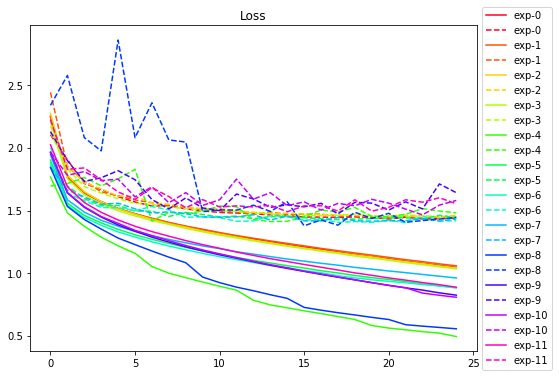

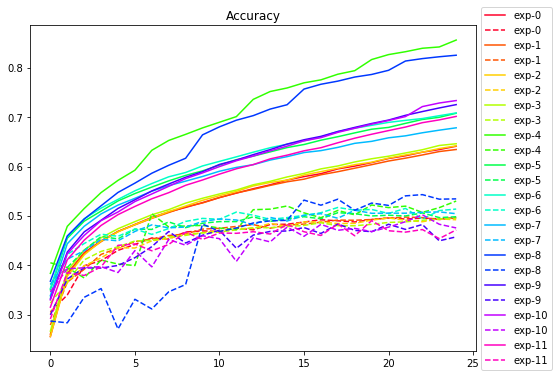

In [17]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()